# BMW car pricing

## Libraries

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
from datetime import datetime

from sklearn import model_selection
import xgboost as xgb #gradient boosting

## Import Data

In [3]:
df = pd.read_csv(r'C:\Users\Jordi Grau\Desktop\Data Science Project\BMW_Regression-1\bmw_pricing_v2.csv', sep=',')

In [4]:
df

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta
0,BMW,118,140411.0,100.0,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300.0,2018-01-01
1,BMW,M4,13929.0,317.0,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700.0,2018-02-01
2,BMW,320,183297.0,120.0,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200.0,2018-02-01
3,BMW,420,128035.0,135.0,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100.0,2018-02-01
4,BMW,425,97097.0,160.0,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400.0,2018-04-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,BMW,218 Gran Tourer,39743.0,110.0,2015-10-01,diesel,black,van,False,True,False,False,False,False,True,False,14600.0,2018-08-01
4839,BMW,218 Active Tourer,49832.0,100.0,2015-06-01,diesel,grey,van,False,True,False,False,False,False,True,True,17500.0,2018-08-01
4840,BMW,218 Gran Tourer,19633.0,110.0,2015-10-01,diesel,grey,van,False,True,False,False,False,False,True,True,17000.0,2018-09-01
4841,BMW,218 Active Tourer,27920.0,110.0,2016-04-01,diesel,brown,van,True,True,False,False,False,False,True,True,22700.0,2018-09-01


# Functions

In [5]:
def plot_cat_values(dataframe, column, target_column):

  plt.figure(figsize=(15, 8))

  ax1 = plt.subplot(2, 1, 1)
  ax1 = sns.countplot(dataframe[column], order = list(dataframe[column].unique()))

  ax2 = plt.subplot(2, 1, 2)
  ax2 = sns.boxenplot(data=dataframe[dataframe[target_column]>0], x=column, y=target_column, order = list(dataframe[column].unique()))

  plt.show()

In [6]:
def explore_cat_values(dataframe, column, target_column):
  results_df = dataframe[dataframe[target_column]>0].pivot_table( index = column, values = TARGET_LN, aggfunc = [len, np.mean])
  results_df.columns = ['cars_bought', 'mean_price_ln']
  results_df['n_rows'] = dataframe[column].value_counts(dropna = False)
  results_df['pct_rows'] = dataframe[column].value_counts(dropna = False, normalize = True)
  results_df['pct_cars_bought'] = results_df['cars_bought']  / results_df['n_rows']
  return results_df[['n_rows', 'pct_rows', 'cars_bought','pct_cars_bought', 'mean_price_ln']]

In [7]:
def set_Bot_Others(dataframe, column, num_values):
  top_cat_list = dataframe[column].value_counts().head(num_values).index.to_list()
  top_cat_list.append('Others')
  dataframe[column] = pd.Categorical(dataframe[column], categories = top_cat_list )
  return dataframe[column].fillna('Others')

In [8]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

# EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        4841 non-null   object 
 1   modelo                       4840 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4842 non-null   float64
 4   fecha_registro               4842 non-null   object 
 5   tipo_gasolina                4838 non-null   object 
 6   color                        4831 non-null   object 
 7   tipo_coche                   4834 non-null   object 
 8   volante_regulable            4839 non-null   object 
 9   aire_acondicionado           4841 non-null   object 
 10  camara_trasera               4841 non-null   object 
 11  asientos_traseros_plegables  4839 non-null   object 
 12  elevalunas_electrico         4841 non-null   object 
 13  bluetooth         

In [10]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4843 entries, 0 to 4842
Columns: 18 entries, marca to fecha_venta
dtypes: bool(1), float64(3), object(14)
memory usage: 648.1+ KB


In [11]:
description = df.describe(include='all').T

In [12]:
description.to_excel('df_description.xlsx')

# Analisis del Target

In [13]:
TARGET = 'precio'

In [14]:
df[TARGET].describe()

count      4837.000000
mean      15831.920612
std        9222.630708
min         100.000000
25%       10800.000000
50%       14200.000000
75%       18600.000000
max      178500.000000
Name: precio, dtype: float64

D:\DS\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='precio', ylabel='Density'>

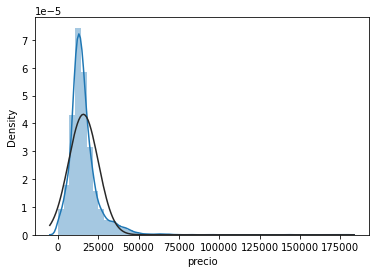

In [15]:
sns.distplot(df[TARGET], fit = stats.norm)

In [16]:
df[TARGET].fillna(df[TARGET].mean(), inplace = True)

In [17]:
df['TARGET_LN'] = df[TARGET].apply(lambda x: np.log10(x))

D:\DS\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TARGET_LN', ylabel='Density'>

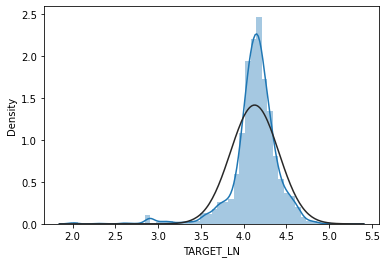

In [18]:
sns.distplot(df['TARGET_LN'], fit = stats.norm)

In [19]:
TARGET_LN = 'TARGET_LN'

# Data Understanding

## Categoricas

### Marca

In [20]:
df['marca'].value_counts(dropna = False)

BMW    4841
NaN       2
Name: marca, dtype: int64

In [21]:
df[df['marca'].isnull()]

,marca,modelo,km,potencia,fecha_registro,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,asientos_traseros_plegables,elevalunas_electrico,bluetooth,gps,alerta_lim_velocidad,precio,fecha_venta,TARGET_LN
161,NaN,520,246424.0,120.0,2010-07-01,diesel,black,estate,True,True,False,False,False,False,True,False,6000.0,2018-08-01,3.778151
210,NaN,320,163879.0,120.0,2012-03-01,diesel,grey,estate,False,False,False,False,False,False,True,False,8600.0,2018-06-01,3.934498


In [22]:
df['marca'].fillna('BMW', inplace = True)

### Modelo

In [23]:
df['modelo'].value_counts(dropna = True)

320                752
520                633
318                568
X3                 438
116                358
                  ... 
M135                 1
225                  1
i8                   1
630                  1
214 Gran Tourer      1
Name: modelo, Length: 76, dtype: int64

In [24]:
df['modelo'].nunique()

76

In [25]:
df['modelo'].fillna('Others_null', inplace=True) #asignamos Others null a los nulos para diferenciarlos de las agrupaciones de las etiquetas con menos observaciones (Others)

In [26]:
explore_cat_values(df, 'modelo', TARGET_LN).sort_values('n_rows', ascending = False).head(12)

,n_rows,pct_rows,cars_bought,pct_cars_bought,mean_price_ln
modelo,,,,,
320,752,0.155276,752,1.0,4.030376
520,633,0.130704,633,1.0,4.163448
318,568,0.117283,568,1.0,3.993292
X3,438,0.090440,438,1.0,4.219014
116,358,0.073921,358,1.0,3.961056
X1,274,0.056577,274,1.0,4.073793
316,235,0.048524,235,1.0,3.971218
X5,231,0.047698,231,1.0,4.437903
525,184,0.037993,184,1.0,4.087024


In [27]:
# Nos quedaremos con el top 11 y los demás le asignaremos la categoria 'Others' para ahcer OHE

In [28]:
# df['modelo'] = set_Bot_Others(df, 'modelo', 11)

### Tipo Gasolina

In [29]:
df['tipo_gasolina'].describe()

count       4838
unique         5
top       diesel
freq        4631
Name: tipo_gasolina, dtype: object

In [30]:
df['tipo_gasolina'].value_counts(dropna=False,normalize=True) # asignaremos 'Others' a lo que este mas abajo del top 2 y OHE

diesel           0.956225
petrol           0.039438
hybrid_petrol    0.001652
NaN              0.001032
Diesel           0.001032
electro          0.000619
Name: tipo_gasolina, dtype: float64

In [31]:
df['tipo_gasolina'] = set_Bot_Others(df, 'tipo_gasolina', 2) 

### Color

In [32]:
df['color'].value_counts(dropna = False)

black     1632
grey      1171
blue       707
white      537
brown      341
silver     327
red         51
beige       41
green       18
NaN         12
orange       6
Name: color, dtype: int64

In [33]:
df['color'].fillna('Others_null', inplace = True)

D:\DS\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


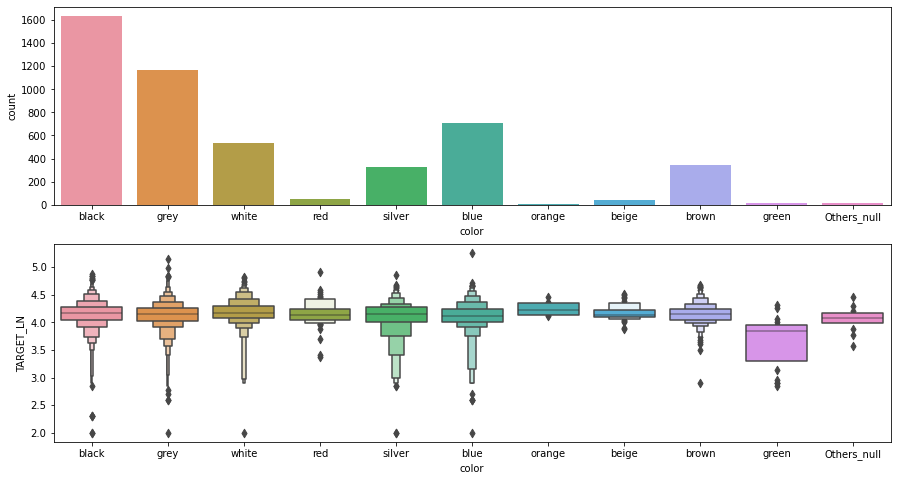

In [34]:
plot_cat_values(df, 'color', TARGET_LN)

In [35]:
# Podemos hacer OHE directo

### Tipo_coche

D:\DS\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


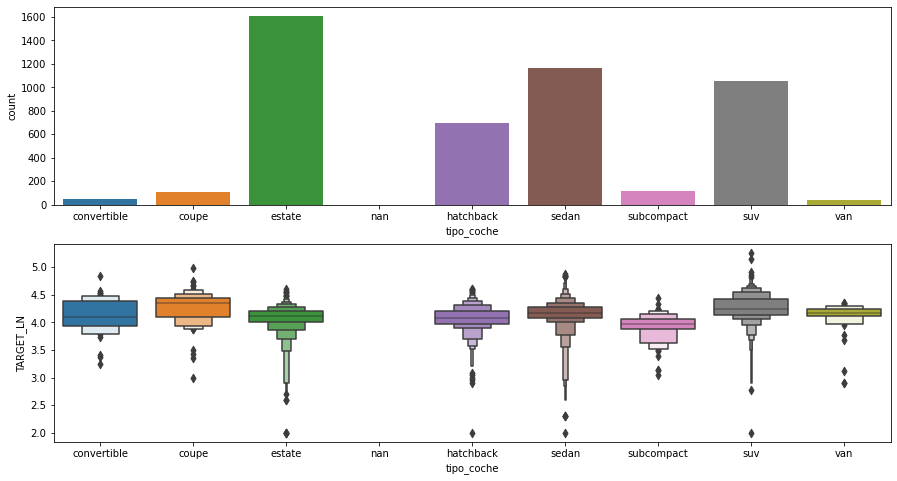

In [36]:
plot_cat_values(df, 'tipo_coche', TARGET_LN)

In [37]:
explore_cat_values(df, 'tipo_coche', TARGET_LN)

,n_rows,pct_rows,cars_bought,pct_cars_bought,mean_price_ln
tipo_coche,,,,,
convertible,47,0.009705,47,1.0,4.125692
coupe,104,0.021474,104,1.0,4.263652
estate,1604,0.331200,1604,1.0,4.063090
hatchback,699,0.144332,699,1.0,4.071932
sedan,1167,0.240966,1167,1.0,4.141627
subcompact,113,0.023333,113,1.0,3.935096
suv,1057,0.218253,1057,1.0,4.264904
van,43,0.008879,43,1.0,4.084499


In [38]:
df['tipo_coche'].isnull().sum()

9

In [39]:
df['tipo_coche'].value_counts(dropna = False)

estate         1604
sedan          1167
suv            1057
hatchback       699
subcompact      113
coupe           104
convertible      47
van              43
NaN               9
Name: tipo_coche, dtype: int64

In [40]:
df['tipo_coche'].fillna('Others_null', inplace = True)

## Dates

### Fecha_registro

In [41]:
df['fecha_registro'].dtype

dtype('O')

In [42]:
df['fecha_registro'] = pd.to_datetime(df['fecha_registro'])

In [43]:
df['fecha_registro'].isnull().sum()

1

### Fecha_venta 

In [44]:
df['fecha_venta'].dtype

dtype('O')

In [45]:
df['fecha_venta'] = pd.to_datetime(df['fecha_venta'])

### imputamos la diferencia entre registro y venta

In [46]:
df['dias_hasta_venta'] = df['fecha_venta']-df['fecha_registro']

### Miramos nulos de las fechas

In [47]:
df['fecha_registro'].isnull().sum()

1

In [48]:
df['fecha_venta'].isnull().sum()

1

In [49]:
df = df.dropna(subset=['fecha_registro'])

In [50]:
df = df.dropna(subset=['fecha_venta'])

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4841 entries, 0 to 4842
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype          
---  ------                       --------------  -----          
 0   marca                        4841 non-null   object         
 1   modelo                       4841 non-null   object         
 2   km                           4839 non-null   float64        
 3   potencia                     4840 non-null   float64        
 4   fecha_registro               4841 non-null   datetime64[ns] 
 5   tipo_gasolina                4841 non-null   category       
 6   color                        4841 non-null   object         
 7   tipo_coche                   4841 non-null   object         
 8   volante_regulable            4837 non-null   object         
 9   aire_acondicionado           4839 non-null   object         
 10  camara_trasera               4839 non-null   object         
 11  asientos_traseros_plegables  4

### creamos variables de las 2 fechas

In [52]:
df['year_registro'] = df['fecha_registro'].dt.year
df['month_registro'] = df['fecha_registro'].dt.month
df['day_registro'] = df['fecha_registro'].dt.day
df['weekday_registro'] = df['fecha_registro'].dt.weekday
df['quarter_registro'] = df['fecha_registro'].dt.quarter
df['week_registro'] = df['fecha_registro'].dt.week
df.drop('fecha_registro', axis = 1, inplace = True)

C:\Users\JORDIG~1\AppData\Local\Temp/ipykernel_5600/4270410957.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_registro'] = df['fecha_registro'].dt.week


In [53]:
df['year_venta'] = df['fecha_venta'].dt.year
df['month_venta'] = df['fecha_venta'].dt.month
df['day_venta'] = df['fecha_venta'].dt.day
df['weekday_venta'] = df['fecha_venta'].dt.weekday
df['quarter_venta'] = df['fecha_venta'].dt.quarter
df['week_venta'] = df['fecha_venta'].dt.week
df.drop('fecha_venta', axis = 1, inplace = True)

C:\Users\JORDIG~1\AppData\Local\Temp/ipykernel_5600/729431141.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['week_venta'] = df['fecha_venta'].dt.week


## Numericas

### km

In [54]:
df['km'].describe()

count    4.839000e+03
mean     1.409291e+05
std      6.019215e+04
min     -6.400000e+01
25%      1.028700e+05
50%      1.410680e+05
75%      1.751955e+05
max      1.000376e+06
Name: km, dtype: float64

In [55]:
df[df['km']<0]

,marca,modelo,km,potencia,tipo_gasolina,color,tipo_coche,volante_regulable,aire_acondicionado,camara_trasera,...,day_registro,weekday_registro,quarter_registro,week_registro,year_venta,month_venta,day_venta,weekday_venta,quarter_venta,week_venta
2938,BMW,640 Gran Coupé,-64.0,230.0,diesel,black,sedan,True,True,False,...,1,2,1,9,2018,4,1,6,2,13


<AxesSubplot:xlabel='modelo', ylabel='km'>

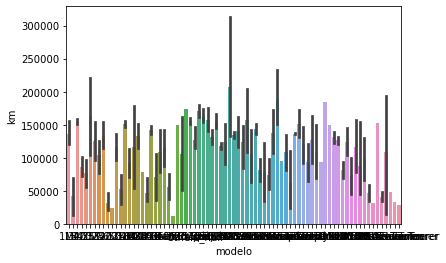

In [56]:
sns.barplot(data = df, x = 'modelo', y = 'km')

In [57]:
df[df['km']>0]['km'].mean()

140958.27284001652

In [58]:
df['km'] = np.where(df['km']<0,df[df['km']>0]['km'].mean(),df['km'])

In [59]:
df['km'].isnull().sum()

2

In [60]:
df['km'].fillna(df[df['km']>0]['km'].mean(), inplace = True)

### Potencia

In [61]:
df['potencia'].describe()

count    4840.000000
mean      128.989669
std        39.000457
min         0.000000
25%       100.000000
50%       120.000000
75%       135.000000
max       423.000000
Name: potencia, dtype: float64

In [62]:
df['potencia'].isnull().sum()

1

In [63]:
df['potencia'].fillna(df['potencia'].mean(), inplace = True)

## Boolean

### volante_regulable

In [64]:
df['volante_regulable'].value_counts(dropna=False)

True     2660
False    2177
NaN         4
Name: volante_regulable, dtype: int64

In [65]:
df['volante_regulable'].fillna(False, inplace = True)

### aire_acondicionado

In [66]:
df['aire_acondicionado'].value_counts(dropna=False)

True     3837
False    1002
NaN         2
Name: aire_acondicionado, dtype: int64

In [67]:
df['aire_acondicionado'].fillna(False, inplace = True)

### camara_trasera

<AxesSubplot:xlabel='camara_trasera', ylabel='count'>

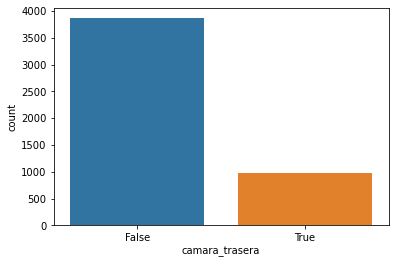

In [68]:
sns.countplot(data = df, x = 'camara_trasera')

In [69]:
df['camara_trasera'].isnull().sum()

2

In [70]:
df['camara_trasera'].fillna(True, inplace = True)

### asientos_traseros_plegables

In [71]:
df['asientos_traseros_plegables'].value_counts(dropna = False)

False    3875
True      962
NaN         4
Name: asientos_traseros_plegables, dtype: int64

In [72]:
df['asientos_traseros_plegables'].fillna(True, inplace = True)

### elevalunas_electrico

In [73]:
df['elevalunas_electrico'].value_counts(dropna = False)

False    2610
True     2229
NaN         2
Name: elevalunas_electrico, dtype: int64

In [74]:
df['elevalunas_electrico'].fillna(True, inplace = True)

### bluetooth

In [75]:
df['bluetooth'].value_counts(dropna = False)

False    3668
True     1169
NaN         4
Name: bluetooth, dtype: int64

In [76]:
df['bluetooth'].fillna(True, inplace = True)

### gps

In [77]:
df['gps'].value_counts(dropna=False)

True     4512
False     329
Name: gps, dtype: int64

### alerta_lim_velocidad

In [78]:
df['alerta_lim_velocidad'].value_counts(dropna = False)

True     2617
False    2222
NaN         2
Name: alerta_lim_velocidad, dtype: int64

In [79]:
df['alerta_lim_velocidad'].fillna(False, inplace = True)

# Cambios de atributos

In [80]:
df['dias_hasta_venta'] = df['dias_hasta_venta'].dt.days

# DataFrame Final

In [81]:
df.describe(include = np.number).T

,count,mean,std,min,25%,50%,75%,max
km,4841.0,140958.272840,60145.571814,476.0,102943.000000,141063.000000,175174.000000,1.000376e+06
potencia,4841.0,128.989669,38.996428,0.0,100.000000,120.000000,135.000000,4.230000e+02
precio,4841.0,15835.342186,9217.029350,100.0,10900.000000,14200.000000,18600.000000,1.785000e+05
TARGET_LN,4841.0,4.129049,0.281761,2.0,4.037426,4.152288,4.269513,5.251638e+00
dias_hasta_venta,4841.0,1980.313365,932.297275,-2009.0,1489.000000,1765.000000,2130.000000,1.025800e+04
year_registro,4841.0,2012.468911,2.525227,1990.0,2012.000000,2013.000000,2014.000000,2.017000e+03
month_registro,4841.0,6.131791,3.315501,1.0,3.000000,6.000000,9.000000,1.200000e+01
day_registro,4841.0,1.000000,0.000000,1.0,1.000000,1.000000,1.000000,1.000000e+00
weekday_registro,4841.0,3.007850,2.023810,0.0,1.000000,3.000000,5.000000,6.000000e+00
quarter_registro,4841.0,2.393720,1.097477,1.0,1.000000,2.000000,3.000000,4.000000e+00


In [82]:
df.describe(exclude = np.number).T

,count,unique,top,freq
marca,4841,1,BMW,4841
modelo,4841,77,320,752
tipo_gasolina,4841,3,diesel,4629
color,4841,11,black,1631
tipo_coche,4841,9,estate,1602
volante_regulable,4841,2,True,2660
aire_acondicionado,4841,2,True,3837
camara_trasera,4841,2,False,3863
asientos_traseros_plegables,4841,2,False,3875
elevalunas_electrico,4841,2,False,2610


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4841 entries, 0 to 4842
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   marca                        4841 non-null   object  
 1   modelo                       4841 non-null   object  
 2   km                           4841 non-null   float64 
 3   potencia                     4841 non-null   float64 
 4   tipo_gasolina                4841 non-null   category
 5   color                        4841 non-null   object  
 6   tipo_coche                   4841 non-null   object  
 7   volante_regulable            4841 non-null   bool    
 8   aire_acondicionado           4841 non-null   bool    
 9   camara_trasera               4841 non-null   bool    
 10  asientos_traseros_plegables  4841 non-null   bool    
 11  elevalunas_electrico         4841 non-null   bool    
 12  bluetooth                    4841 non-null   bool    
 13  gps

### Transformamos los booleans

In [84]:
bool_columns = df.select_dtypes(include=bool).columns
category_columns = df.select_dtypes(include='category').columns

In [85]:
for col in bool_columns:
    df[col] = list(map(int, df[col]))

### Transformamos las category en object

In [86]:
for col in category_columns:
    df[col] = df[col].astype(object)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4841 entries, 0 to 4842
Data columns (total 30 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   marca                        4841 non-null   object 
 1   modelo                       4841 non-null   object 
 2   km                           4841 non-null   float64
 3   potencia                     4841 non-null   float64
 4   tipo_gasolina                4841 non-null   object 
 5   color                        4841 non-null   object 
 6   tipo_coche                   4841 non-null   object 
 7   volante_regulable            4841 non-null   int64  
 8   aire_acondicionado           4841 non-null   int64  
 9   camara_trasera               4841 non-null   int64  
 10  asientos_traseros_plegables  4841 non-null   int64  
 11  elevalunas_electrico         4841 non-null   int64  
 12  bluetooth                    4841 non-null   int64  
 13  gps               

# OHE

In [88]:
def OHE(dataframe, column):
  dummies_ds = pd.get_dummies(dataframe[column], prefix = column)
  dataframe = pd.concat([dataframe, dummies_ds], axis = 1)
  return dataframe.drop(column, axis = 1)

In [89]:
for col in df.describe(include = np.object).columns:
  df = OHE(df, col)

C:\Users\JORDIG~1\AppData\Local\Temp/ipykernel_5600/4194365281.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  for col in df.describe(include = np.object).columns:


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4841 entries, 0 to 4842
Columns: 126 entries, km to tipo_coche_van
dtypes: float64(4), int64(21), uint8(101)
memory usage: 1.6 MB


# Separar dataset en dev y val

In [91]:
df.pivot_table(index = ['year_venta', 'month_venta'], values = TARGET_LN, aggfunc = len)

TARGET_LN
year_venta month_venta           
2007       8                    1
2008       6                    1
2009       4                    1
2010       4                    1
2018       1                  208
           2                  502
           3                  738
           4                  691
           5                  809
           6                  602
           7                  537
           8                  527
           9                  223

In [92]:
df_val = df[df['year_venta'] * 100 + df['month_venta'] >= 201808]
df_dev = df[df['year_venta'] * 100 + df['month_venta'] < 201808]

In [93]:
df_val.shape

(750, 126)

In [94]:
df_dev.shape

(4091, 126)

In [95]:
df_val_X = df_val.drop([TARGET_LN,TARGET], axis = 1)
df_val_y = df_val[[TARGET_LN]]

df_dev_X = df_dev.drop([TARGET_LN,TARGET], axis = 1)
df_dev_y = df_dev[[TARGET_LN]]

In [96]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    df_dev_X,
    df_dev_y,
    random_state = 1,
    test_size = 0.3
)

# Primer Algoritmo

In [97]:
first_model = xgb.XGBRegressor(random_state = 42, max_depth = 3, n_estimators = 100)

In [98]:
first_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [99]:
test_prediction = pd.DataFrame(first_model.predict(X_test), columns = ['Prediction'], index = X_test.index)

In [100]:
results_df = y_test.join(test_prediction)

In [101]:
results_df.sort_values(by=TARGET_LN, ascending = False).head(10)

,TARGET_LN,Prediction
4146,4.915927,4.920838
1,4.843233,4.735820
3320,4.834421,4.775104
4110,4.800029,4.706512
2678,4.795880,4.638240
68,4.741939,4.696797
4066,4.696356,4.678086
4233,4.667453,4.663531
115,4.660865,4.672694
4271,4.650308,4.651611


## Métricas de validación

In [102]:
results_df['error'] = results_df[TARGET_LN] - results_df['Prediction']
results_df['squared_error'] = (results_df['error'] ** 2)
results_df['root_squared_error'] = np.sqrt(results_df['squared_error'])

In [103]:
mse = results_df['squared_error'].mean()
rmse = results_df['root_squared_error'].mean()

In [104]:
rmse

0.07992163997116415

D:\DS\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='root_squared_error', ylabel='Density'>

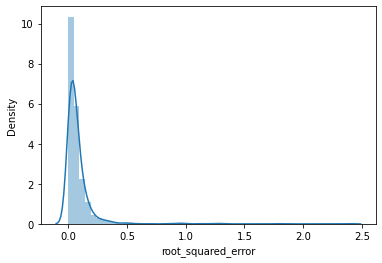

In [105]:
sns.distplot(
    results_df['root_squared_error']
)

In [106]:
results_df.sort_values(by=TARGET_LN, ascending = False).head(15)

,TARGET_LN,Prediction,error,squared_error,root_squared_error
4146,4.915927,4.920838,-0.004911,0.000024,0.004911
1,4.843233,4.735820,0.107413,0.011538,0.107413
3320,4.834421,4.775104,0.059317,0.003518,0.059317
4110,4.800029,4.706512,0.093517,0.008746,0.093517
2678,4.795880,4.638240,0.157640,0.024850,0.157640
68,4.741939,4.696797,0.045142,0.002038,0.045142
4066,4.696356,4.678086,0.018270,0.000334,0.018270
4233,4.667453,4.663531,0.003922,0.000015,0.003922
115,4.660865,4.672694,-0.011828,0.000140,0.011828
4271,4.650308,4.651611,-0.001304,0.000002,0.001304


# Segundo algoritmo

In [108]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

In [111]:
regr_model = model.fit(X_train, y_train)

In [112]:
test_prediction_r = pd.DataFrame(regr_model.predict(X_test), columns = ['Prediction'], index = X_test.index)

In [113]:
results_df_r = y_test.join(test_prediction_r)

In [114]:
results_df_r.columns = ['Target', 'Prediction']

In [115]:
results_df_r['error'] = results_df_r['Target'] - results_df_r['Prediction']
results_df_r['sqr_error'] = results_df_r['error']**2
results_df_r['root_sqr_error'] = np.sqrt(results_df_r['sqr_error'])

In [116]:
mse_red = results_df_r['sqr_error'].mean()
rmse_red = results_df_r['root_sqr_error'].mean()

In [119]:
rmse_red

0.07831390413525602

D:\DS\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='root_sqr_error', ylabel='Density'>

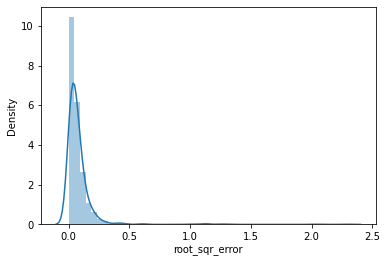

In [117]:
sns.distplot(
    results_df_r[results_df_r['Target']>0]['root_sqr_error']
)

In [118]:
results_df_r.sort_values(by='Target', ascending = False).head(15)

,Target,Prediction,error,sqr_error,root_sqr_error
4146,4.915927,4.939099,-0.023172,0.000537,0.023172
1,4.843233,4.873583,-0.030350,0.000921,0.030350
3320,4.834421,4.775896,0.058525,0.003425,0.058525
4110,4.800029,4.687890,0.112139,0.012575,0.112139
2678,4.795880,4.666905,0.128975,0.016635,0.128975
68,4.741939,4.813915,-0.071976,0.005181,0.071976
4066,4.696356,4.656251,0.040106,0.001608,0.040106
4233,4.667453,4.657041,0.010412,0.000108,0.010412
115,4.660865,4.783030,-0.122164,0.014924,0.122164
4271,4.650308,4.628941,0.021366,0.000457,0.021366


# Conclusiones

##### Hemos realizado la predicción con un error muy mínimo del TARGET_LN con XGBOOST.
##### Hemos realizado la predicción con un error aun menor que con XGBOOST con regresión lineal. (utilizariamos la regresión lineal para el modelo)